[IGRA (Integrated Global Radiosonde Archive) data](https://www1.ncdc.noaa.gov/pub/data/igra/)

In [7]:
import sys, re
sys.path.append('../python/')
from data.IGRA import Monthly
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs

In [3]:
%matplotlib nbagg

In [79]:
def anplot(x, ax=None, color=None):
    ax = plt.gca() if ax is None else ax
    p = ax.scatter(*x.as_matrix().T, marker='o', transform=crs.PlateCarree(), color=color)
    for i, st in x.dropna().iterrows():
        ax.annotate(i, xy=st, xycoords=crs.PlateCarree()._as_mpl_transform(ax), color=p.get_facecolor()[0])
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180, 180, -65, -90), crs.PlateCarree())
    return p

In [80]:
def set_logic(a, b):
    a, b = a.dropna(), b.dropna()
    i = a.index.intersection(b.index)
    return a.loc[a.index.difference(i)], b.loc[b.index.difference(i)], a.loc[i]

## Stations

In [38]:
# IGRA (radiosonde archive)
ista = Monthly.read_stations('../../data/IGRA/igra2-station-list.txt').query('lat<=-60')

# READER (BAS) and NCDC
with pd.HDFStore('../../data/Antarctica/stations.h5') as S:
    sta = S['sta']

In [9]:
ista.loc[89611]

id            AYM00089611
lat              -66.2825
lon               110.523
elev                   40
state                 NaN
name                CASEY
first_year           1957
last_year            2017
nobs                39636
Name: 89611, dtype: object

In [2]:
x = Monthly.tar_to_xarray('../../data/IGRA/IGRA-mly.tar.gz', ['AYM00089611'])

### NCDC vs READER stations

<IPython.core.display.Javascript object>


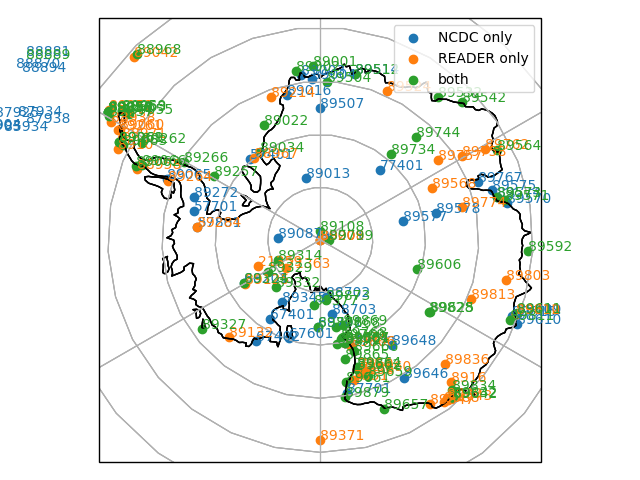

In [170]:
ncdc_sta, read_sta, both_sta = set_logic(sta[['longitude', 'latitude']], sta[['Longitude', 'Latitude']])

plt.figure()
ax = plt.axes(projection=crs.SouthPolarStereo())

plt.legend([anplot(ncdc_sta), anplot(read_sta), anplot(both_sta)],
    ['NCDC only', 'READER only', 'both'])

plt.tight_layout()

In [4]:
with pd.HDFStore('../../data/Antarctica/READER.h5') as S:
    reader = pd.concat((S['sfc'], S['aws']), 1)
    # drop station with less than 12 months of data
    reader.drop(
        (reader.groupby(axis=1, level=0).apply(lambda x:x.count().max()) < 12).replace(False, float('nan')).dropna().index,
        1, 0, inplace=True
    )

In [76]:
from geo import box

In [77]:
w = set(z[0] for z in filter(lambda s:re.search('wind', s[1]), reader.columns.tolist()))

<IPython.core.display.Javascript object>


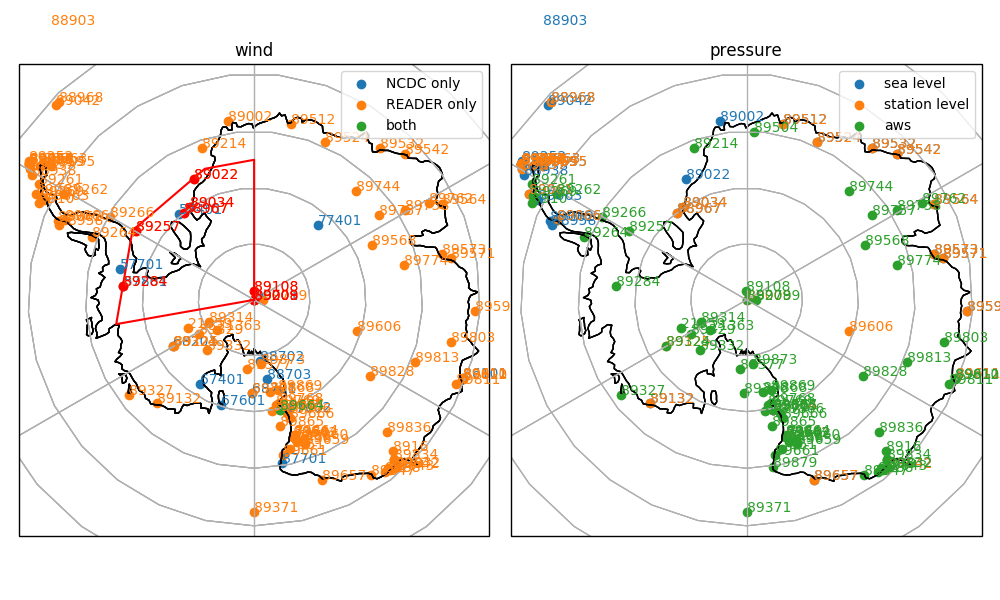

In [81]:
wab = box(-100, 0, -90, -75)

ncdc_wind, read_wind, both_wind = set_logic(
    sta[sta.WIND==True][['longitude', 'latitude']],
    sta.loc[w][['Longitude', 'Latitude']]
)

fig, axs = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': crs.SouthPolarStereo()})

axs[0].legend([anplot(ncdc_wind, axs[0]), anplot(read_wind, axs[0]), anplot(both_wind, axs[0])],
           ['NCDC only', 'READER only', 'both'])
axs[0].set_title('wind')
axs[0].plot(*wab.rect, color='r', transform=crs.PlateCarree())
anplot(wab.stations(sta, 'Longitude', 'Latitude'), axs[0], 'r')

ll = ['Longitude', 'Latitude']
axs[1].legend(
    [anplot(sta.loc[reader.xs(s, 1, 1).dropna(0, 'all').columns.get_level_values(0).unique(), ll], axs[1])
     for s in ['msl_pressure', 'station_level_pressure', 'pressure']],
    ['sea level', 'station level', 'aws'])
axs[1].set_title('pressure')

plt.tight_layout()

In [139]:
m = reader.xs('wind_direction', 1, 1).groupby(axis=1,level=0).apply(lambda g:g.sum(1)).dropna(0, 'all').notnull()
b = np.where(m.columns.isin(wab.stations(sta, 'Longitude', 'Latitude').index))[0]
c = np.where(sta.loc[m.columns]['type'].str.contains('sfc'))[0] # includes 'sfc+aws'
m.columns = ['{} - {}'.format(s[1], s[0]) for s in sta.loc[m.columns]['Name'].iteritems()]

In [121]:
from spatial_stats import Blocks
from sklearn.tree import DecisionTreeClassifier
B = Blocks(DecisionTreeClassifier, min_samples_leaf=36)
B.compute(m.replace(False, np.nan))

In [125]:
B.compute(m.replace(False, np.nan))

In [145]:
from helpers import availability_matrix as avail

<IPython.core.display.Javascript object>


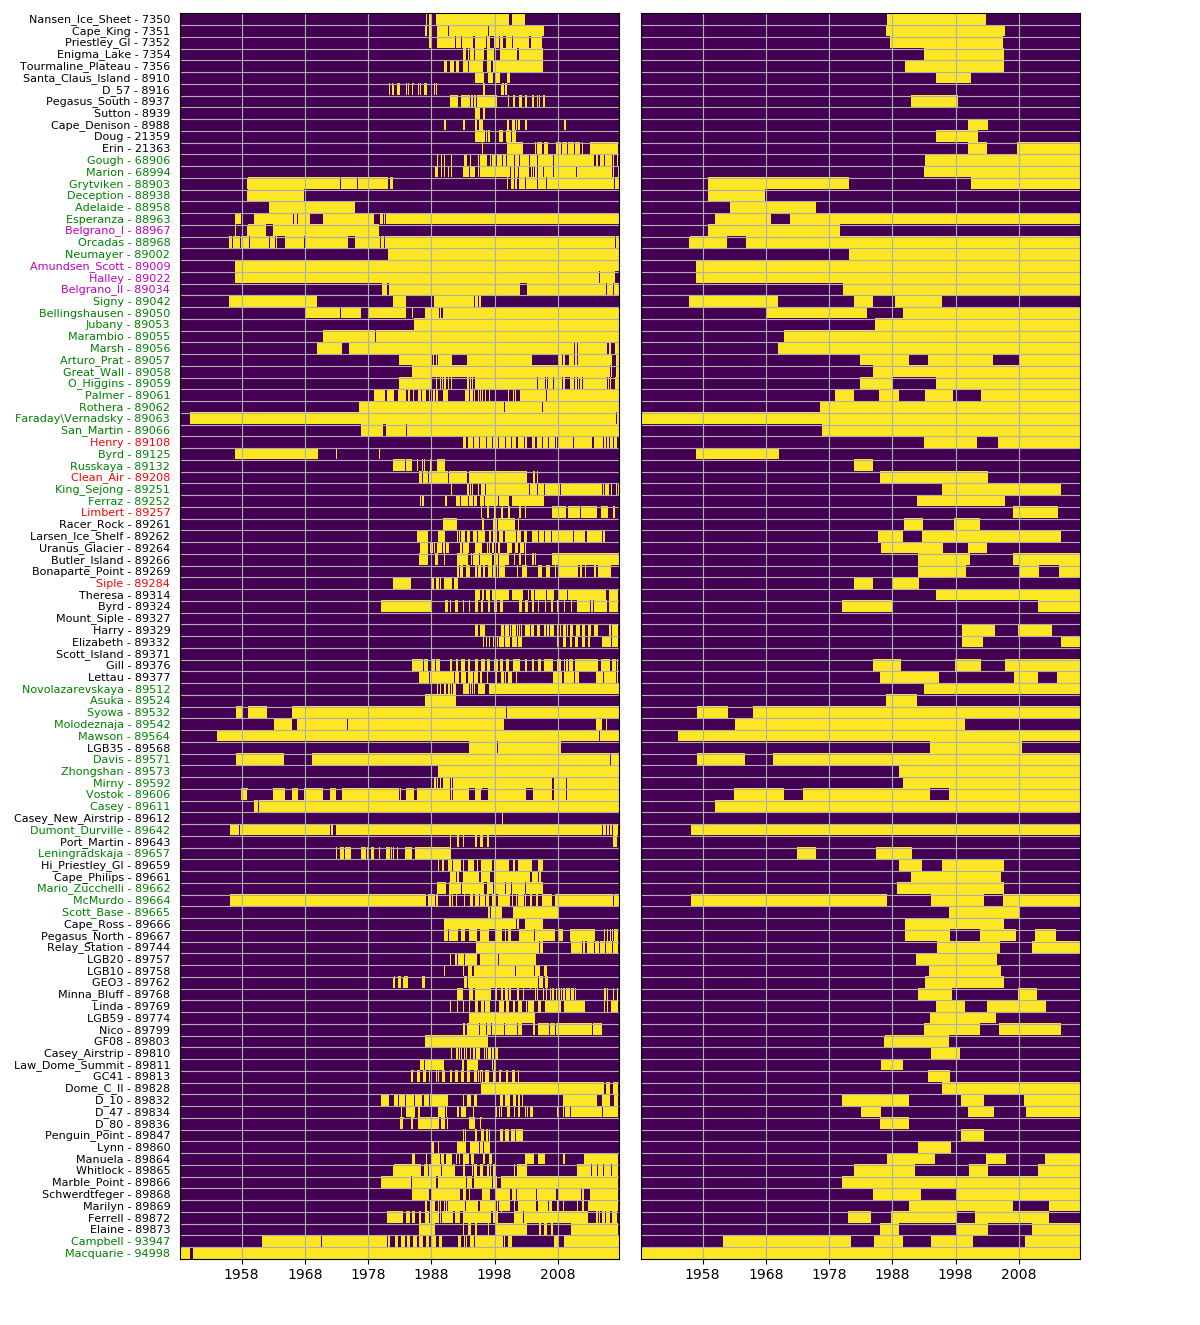

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(12, 0.125*m.shape[1]))
avail(m, left=.15, ax=axs[0],
                       color={'r':set(b)-set(c), 'g':set(c)-set(b), 'm':set(c).intersection(b)})
avail(B.check().astype(float), ax=axs[1], label=False, wspace=.05)